# Porto Seguro's Safe Drive Prediction

# 1. Data Preparation and Exploration

## Loading Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv('data/porto_train.csv')
test = pd.read_csv('data/porto_test.csv')

In [3]:
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (595212, 59)
Test shape:  (892816, 58)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [5]:
data = []

for feature in train.columns:
    if feature == 'target':
        role = 'target'
    elif feature == 'id':
        role = 'id'
    else:
        role=  'input'
    
    if 'bin' in feature or feature == 'target':
        level = 'binary'
    elif 'cat' in feature or feature == 'id':
        level = 'nominal'
    elif train[feature].dtype == float:
        level = 'interval'
    else:
        level = 'ordinal'
        
    keep = True
    if feature == 'id':
        keep = False
        
    dtype = train[feature].dtype
    
    feature_dict = {
        'varname' : feature,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(feature_dict)
    
meta = pd.DataFrame(data, columns = ['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace = True)

In [6]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [7]:
pd.DataFrame(meta.groupby(['role' , 'level'])['level'].count())

level
role   level          
id     nominal       1
input  binary       17
       interval     10
       nominal      14
       ordinal      16
target binary        1

## Descriptive Statistics

### 1) Interval variables

In [8]:
v = meta[(meta['level'] == 'interval') & (meta['keep'])].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


1-1) reg variables
- ps_reg_03 변수에만 Missing Value가 존재한다.
- 변수 간 Min-Max가 다르기 때문에 StandardScaler를 사용해볼 수 있다. 

1-2) car variables

- ps_car_12, ps_car_15에 Missing Value가 존재한다.
- 마찬가지로 Min-Max가 다르기 때문에 StandardScaler를 사용해볼 수 있다.

1-3) calc variables

- Missing Value가 없음
- Max가 동일함
- _calc로 끝나는 세 개의 변수들의 분포가 유사해보인다.

### 2) Ordinal variables

In [9]:
v = meta[(meta['level'] == 'ordinal') & (meta['keep'])].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- ps_car_11에 Missing Value가 존재한다.
- 범위가 다른 것에 스케일링을 적용해볼 수 있다.

### 3) Binary variables

In [10]:
v = meta[(meta['level'] == 'binary') & (meta['keep'])].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


mean 값을 통해 대부분의 값이 0이라는 것을 짐작할 수 있다.

## Handling Imbalanced classes

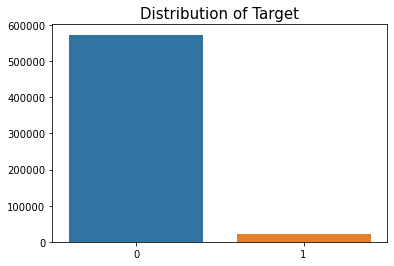

In [11]:
sns.barplot(x = train['target'].value_counts().index, y = train['target'].value_counts().values)
plt.title('Distribution of Target', size = 15)
plt.show()

undersampling은 다른 클래스에 비해 상대적으로 많이 나타나있는 클래스의 개수를 줄이는 것입니다. 

이를 통해 균형을 유지할 수 있게 되지만, 제거하는 과정에서 유용한 정보가 버려지게 되는 것이 큰 단점입니다. 

oversampling은 데이터를 복제하는 것입니다. 무작위로 하는 경우도 있고, 기준을 미리 정해서 복제하는 방법도 있습니다.

정보를 잃지 않고, 훈련용 데이터에서 높은 성능을 보이지만 실험용 데이터에서의 성능은 낮아질 수 있습니다. 

대부분의 oversampling 방법은 Overfitting의  문제를 포함하고 있습니다.

데이터 수가 많기 때문에 undersampling을 택하겠다.

In [12]:
desired_apriori = 0.1

idx_0 = train[train['target'] == 0].index
idx_1 = train[train['target'] == 1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# target (1)은 0.9, target(0)은 0.1
undersampling_rate = ((1-desired_apriori) * nb_1) / (desired_apriori * nb_0)

undersampled_nb0 = int(undersampling_rate  * nb_0)
print('target(0)에 대한 undersampling 비율: {}'.format(undersampling_rate))
print('Undersampling 이후 target(0) 데이터 개수: {} '.format(undersampled_nb0))

# target(0)에 대한 전체 index 중, undersampling 개수를 지정해 랜덤으로 index를 설정
undersampled_idx = shuffle(idx_0, random_state = 37, n_samples = undersampled_nb0)

# undersampling 된 index의 리스트와 기존 target(1)인 index를 합친 list 생성
idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop = True)

target(0)에 대한 undersampling 비율: 0.34043569687437886
Undersampling 이후 target(0) 데이터 개수: 195246 


## Data Quality Checks

### Checking Missing Values

In [13]:
vars_with_missing = []

for feature in train.columns:
    missings = train[train[feature] == -1][feature].count()
    
    if missings > 0:
        vars_with_missing.append(feature)
        missing_percent = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with Missing Values'.format(feature, missings, missing_percent))

Variable ps_ind_02_cat has 103 records (0.05%) with Missing Values
Variable ps_ind_04_cat has 51 records (0.02%) with Missing Values
Variable ps_ind_05_cat has 2256 records (1.04%) with Missing Values
Variable ps_reg_03 has 38580 records (17.78%) with Missing Values
Variable ps_car_01_cat has 62 records (0.03%) with Missing Values
Variable ps_car_02_cat has 2 records (0.00%) with Missing Values
Variable ps_car_03_cat has 148367 records (68.39%) with Missing Values
Variable ps_car_05_cat has 96026 records (44.26%) with Missing Values
Variable ps_car_07_cat has 4431 records (2.04%) with Missing Values
Variable ps_car_09_cat has 230 records (0.11%) with Missing Values
Variable ps_car_11 has 1 records (0.00%) with Missing Values
Variable ps_car_14 has 15726 records (7.25%) with Missing Values


- ps_car_03_cat and ps_car_05_cat은 상당히 많은 결측치를 보임.

- ps_reg_03(continuous)은 약 18%의 결측치를 보임. 평균으로 대체

- ps_car_11(ordinal)은 5개의 결측치를 보인다. 최빈값으로 대체

- ps_car_12(continuous)는 1개의 결측치를 보인다. 평균으로 대체

- ps_car_14(continuous)는 7%의 결측치를 보인다. 평균으로 대체

In [14]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, axis = 1, inplace = True)
meta.loc[(vars_to_drop), 'keep'] = False

In [15]:
# 평균, 최빈값으로 대치
mean_imp = SimpleImputer(missing_values = -1, strategy ='mean')
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')

# 다차원 배열(array)를 1차원 배열로 평평하게 펴주는 Numpy의 ravel() 함수를 사용
# ex) array([[0.83], [0.72]]) -> array([0.83], [0.72])

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_12'] = mode_imp.fit_transform(train[['ps_car_12']]).ravel()

### Checking the cardinality of the categorical variables

Cardinality는 변수 안에 서로 다른 unique한 값의 개수를 말한다.

Categorical 변수에 많은 Distinct value가 있으면 더미 변수가 너무 많아지므로 분석에 좋지않다.

In [16]:
v = meta[(meta['level'] == 'nominal') & (meta['keep'])].index

for feature in v:
    distinct_value = train[feature].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(feature, distinct_value))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


ps_car_11은 상당히 많은 값들을 가지고 있다. 적절한 처리가 필요해보인다.

### Tip : Encoding에 대해서

<b> 1. One-Hot Endoing</b>

장점:

피쳐내 값들이 서로 분리 되어있으므로, 어떤 관계나 영향을 주지 않고, 구현이 매우 쉽다.

단점:

High Cardinality를 가질 경우 매우 많은 Feature가 생긴다. -> 차원의 저주

0,1으로만 구성되어 Tree의 Depth를 깊게 만듦. 

Random Forest과 같은 트리 기반 모델 사용시, 일부 feature만 sampling 하는 경우가 많다. 이때 One-hot encoding을 한 feature가 많다면 다른 feature들보다 더욱 많이 사용된다.

<b> 2. Label Encoding </b>

장점:

One-hot encoding과 달리, 많은 feature들을 생성하지 않고 하나의 Labeled Feature만 만든다.

One-hot encoding보다 학습 속도가 빠르며, One-hot encoding의 단점을 어느정도 보완하며, 구현하기 쉽다.

단점:
    
한 Feature 내에 Numerical하게 Encoding을 하므로 순서개념을 전제하여 학습하게 된다. (2 > 1)

Linear Regression 모델에는 적합하지 않다.

<b> 3. Mean Encoding </b>
위 Encoding 방법들은 0,1로 Encoding 하기 때문에  값 자체의 의미는 없다.

장점:

만들어지는 Feature의 수가 매우 적어 차원의 저주가 없고, 빠른 학습이 이루어진다.

Less bias

단점:

구현과 검증이 까다롭다.

Overfitting의 문제가 있다.
- Data Leakage: train 데이터에는 예측값에 대한 정보가 들어가면  안 되지만, Mean Encoding 과정에는 예측값에 대한 정보가 포함된다. 그래서 Overfitting이 발생

- label의 대푯값을 train의 mean으로 사용한다. test dataset의 label 값의 통계적 분포가 다르다면 overfitting이 발생한다. -> Smoothing

In [17]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series = None,
                  tst_series = None,
                  target = None,
                  min_samples_leaf = 1,
                  smoothing = 1,
                  noise_level = 0):
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis = 1)
    averages = temp.groupby(trn_series.name)[target.name].agg(['mean', 'count'])
    
    # Compute Smoothing
    smoothing = 1 / (1 + np.exp(-(averages['count'] - 100) / 10))
    prior = target.mean()
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis = 1, inplace = True)
    
    # Apply average to trn and tst series
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                        averages.reset_index().rename(columns = {'index': target.name, target.name : 'average'}),
                        on = trn_series.name,
                        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_trn_series.index = trn_series.index
    
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                        averages.reset_index().rename(columns = {'index': target.name, target.name : 'average'}),
                        on = tst_series.name,
                        how = 'left')['average'].rename(tst_series.name + '_mean').fillna(prior)
    
    ft_tst_series = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [18]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], 
                                            test['ps_car_11_cat'], 
                                            target = train['target'], 
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.1)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis = 1, inplace = True)

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis = 1, inplace = True)

meta.loc['ps_car_11_cat', 'keep'] = False

## EDA

In [19]:
v = meta[(meta['level'] == 'nominal') & (meta['keep'])].index

def plot_categorical(data):
    for feature in data:
        plt.figure()
        fig, ax = plt.subplots(figsize = (10,8))
        
        cat_percent = train[[feature, 'target']].groupby(feature, as_index = False).mean()
        cat_percent = cat_percent.sort_values(ascending = False, by = 'target')
        
        sns.barplot(ax = ax , x= feature, y = 'target', data = cat_percent, order=cat_percent[feature])
        plt.title('Distribution of {}'.format(feature), size = 15)
        plt.show()

<Figure size 432x288 with 0 Axes>

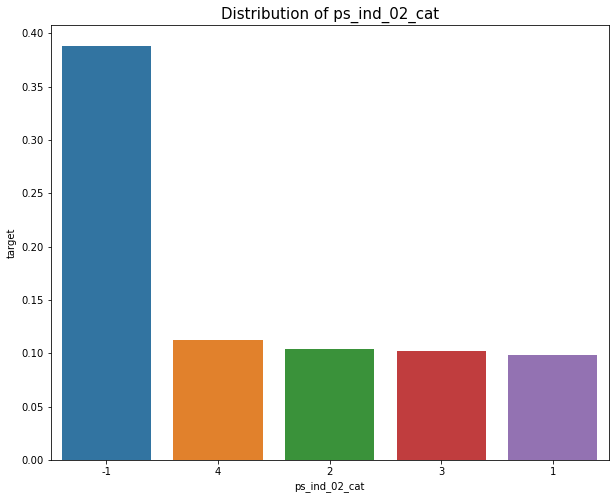

<Figure size 432x288 with 0 Axes>

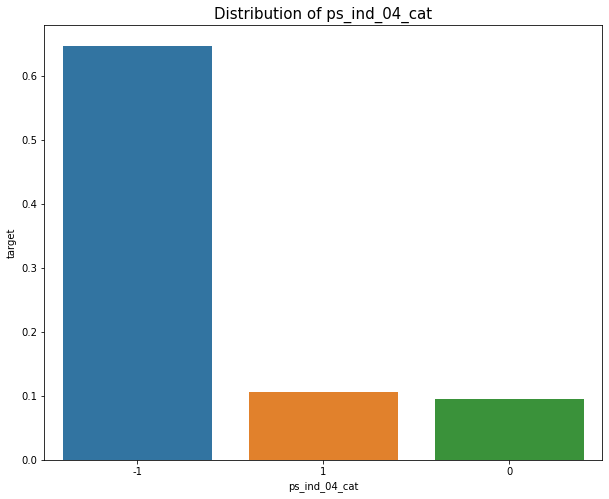

<Figure size 432x288 with 0 Axes>

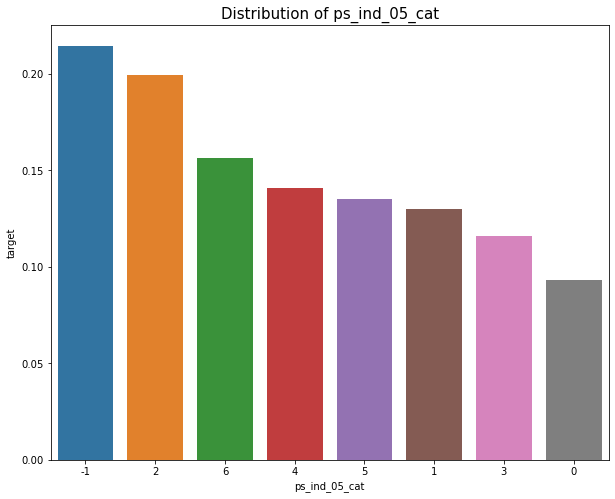

<Figure size 432x288 with 0 Axes>

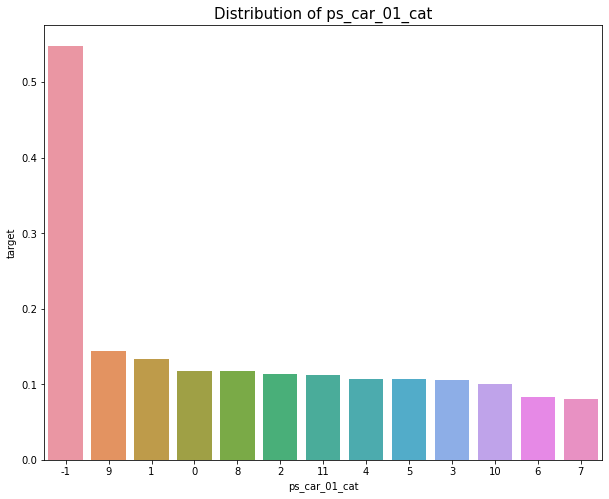

<Figure size 432x288 with 0 Axes>

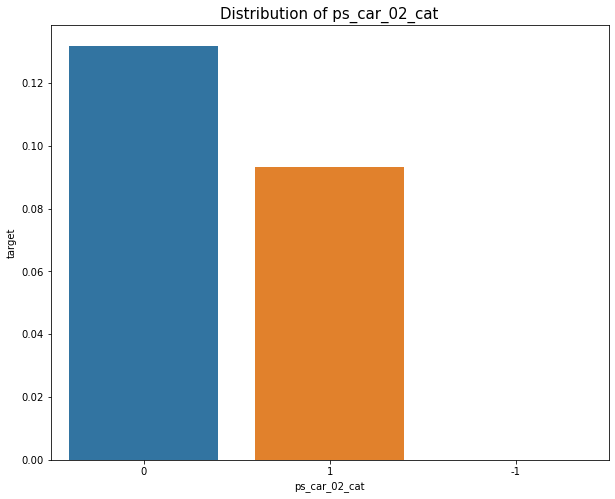

<Figure size 432x288 with 0 Axes>

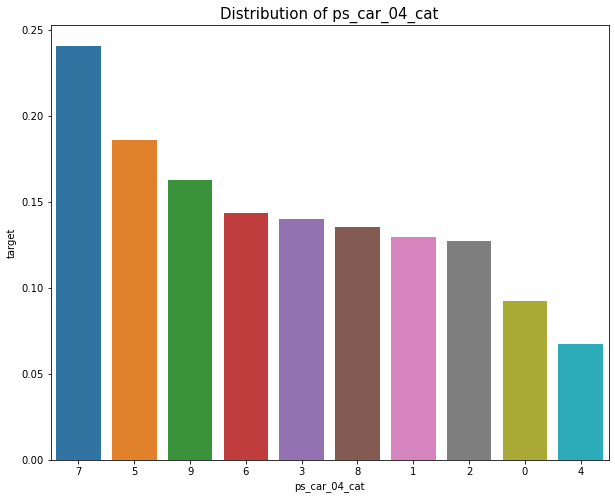

<Figure size 432x288 with 0 Axes>

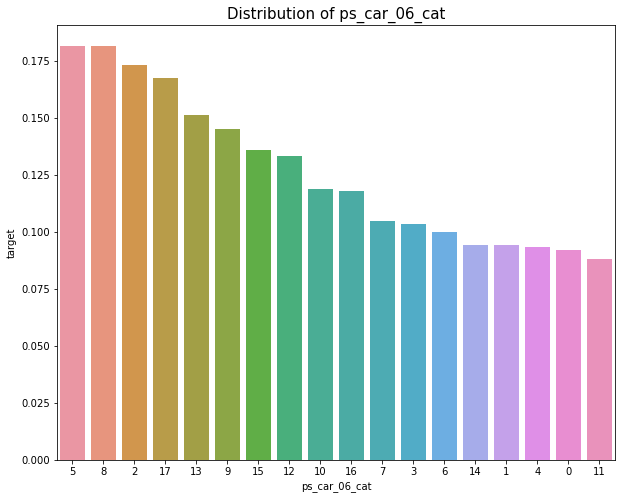

<Figure size 432x288 with 0 Axes>

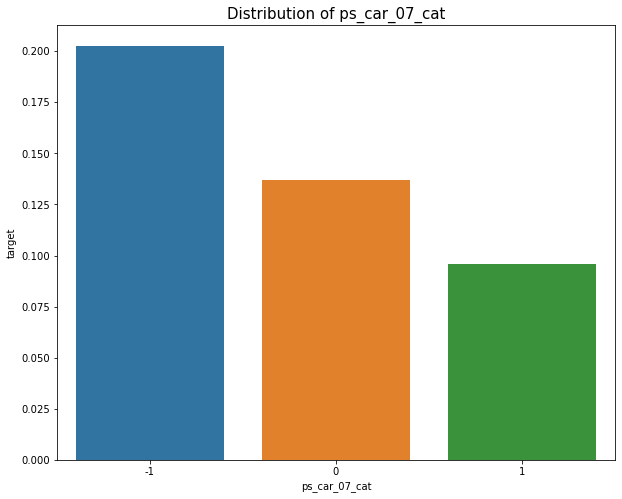

<Figure size 432x288 with 0 Axes>

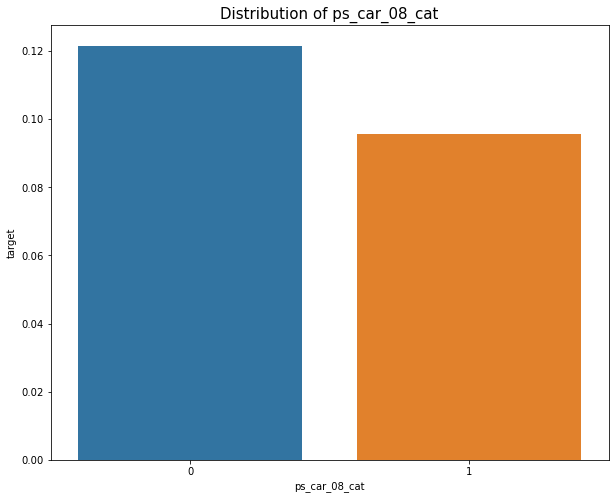

<Figure size 432x288 with 0 Axes>

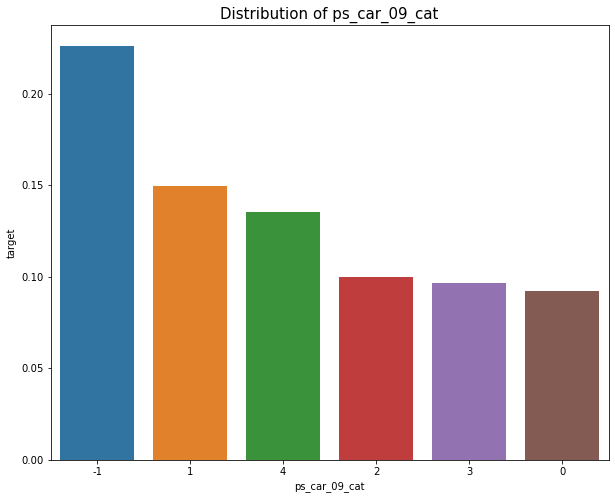

<Figure size 432x288 with 0 Axes>

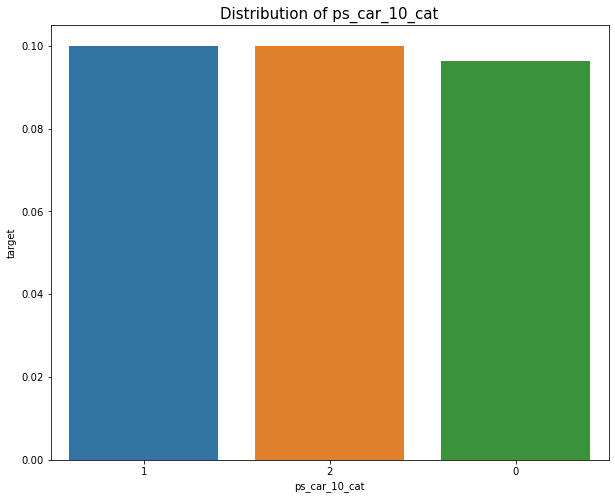

In [20]:
plot_categorical(train[v])

### Interval variables

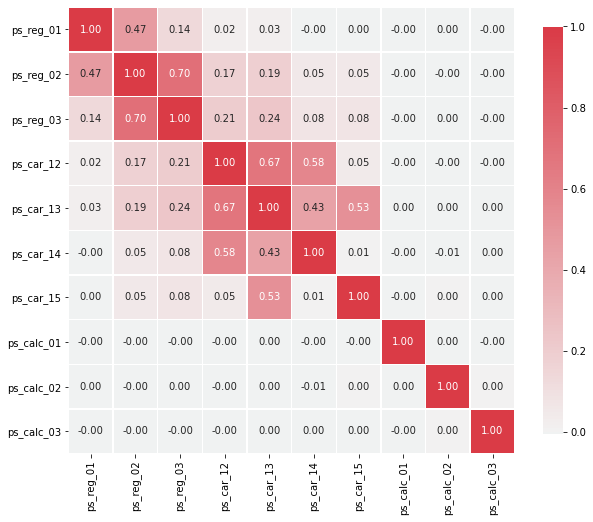

In [21]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    cmap = sns.diverging_palette(220, 10,  as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10,10))
    
    sns.heatmap(correlations, cmap = cmap, vmax = 1.0, center = 0, fmt = '.2f', square=True, linewidth = .5, annot = True, cbar_kws = {'shrink' : 0.75})
    plt.show()
    
v = meta[(meta['level'] == 'interval') & (meta['keep'])].index
corr_heatmap(v)

- ps_reg_02 and ps_reg_03 (0.70)

- ps_car_12 and ps_car13 (0.67)

- ps_car_12 and ps_car_14 (0.58)

- ps_car_13 and ps_car_15 (0.67)

<b> 1) ps_reg_02 and ps_reg_03 </b>

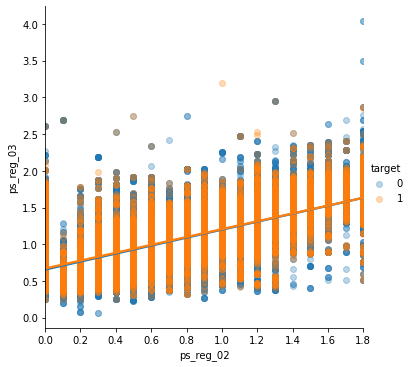

In [22]:
sns.lmplot(x = 'ps_reg_02', y = 'ps_reg_03', data = train, hue = 'target', scatter_kws = {'alpha' : 0.3})
plt.show()

<b> 2) ps_car_12 and ps_car_13 </b>

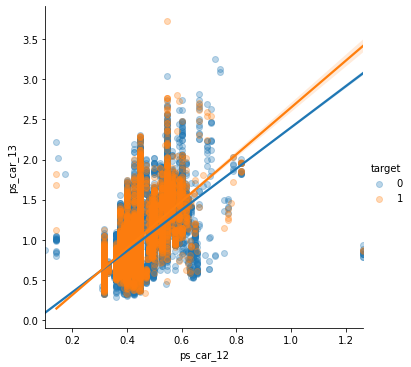

In [23]:
sns.lmplot(x = 'ps_car_12', y = 'ps_car_13', data = train, hue = 'target', scatter_kws = {'alpha' : 0.3})
plt.show()

<b> 3) ps_car_12 and ps_car_14 </b>

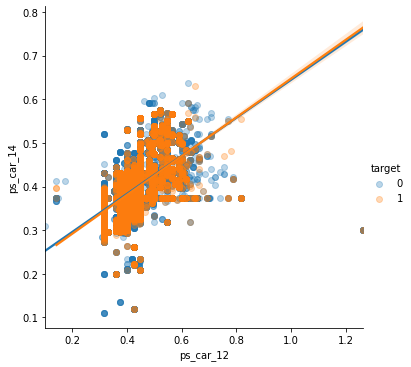

In [24]:
sns.lmplot(x = 'ps_car_12', y = 'ps_car_14', data = train, hue = 'target', scatter_kws = {'alpha' : 0.3})
plt.show()

<b> 4) ps_car_13 and ps_car_15 </b>

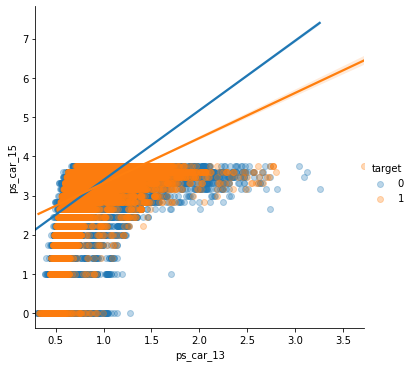

In [25]:
sns.lmplot(x = 'ps_car_13', y = 'ps_car_15', data = train, hue = 'target', scatter_kws = {'alpha' : 0.3})
plt.show()

### Checking the Correlation between Ordinal Variables

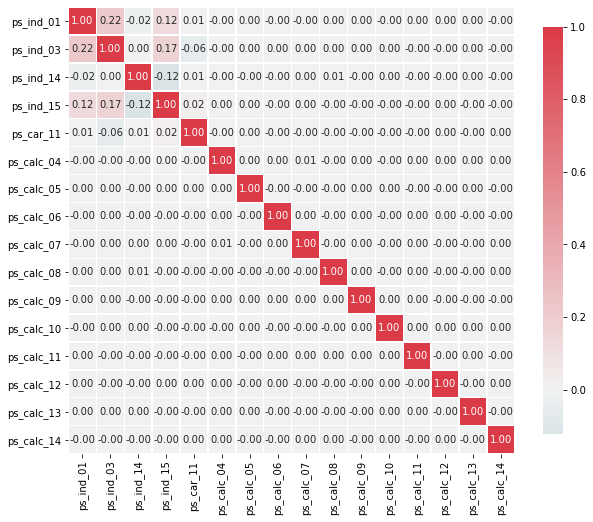

In [26]:
v= meta[(meta['level'] == 'ordinal') & (meta['keep'])].index
corr_heatmap(v)

## Feature Engineering 

<b> 1) Dummification </b>

Mean Encoding을 한 변수 제외 One-hot encoding을 통해 더미화 시켜준다.

In [27]:
nominal = meta[(meta['level'] == 'nominal') & (meta['keep'])].index

print('trainsets Before Onehot Encoding: ', train.shape[1])
train = pd.get_dummies(data = train, columns = nominal, drop_first =True)
test = pd.get_dummies(data =test, columns = nominal, drop_first = True)
print('trainsets After Onehot Encoding: ', train.shape[1])

trainsets Before Onehot Encoding:  57
trainsets After Onehot Encoding:  109


<b> 2) Creating Interaction variables </b>

In [33]:
v= meta[(meta['level'] == 'interval') & (meta['keep'])].index
poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)
interactions = pd.DataFrame(data = poly.fit_transform(train[v]), columns = poly.get_feature_names(v))
interactions.drop(v, axis = 1, inplace = True)

# interactions + train

print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis =1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 154 variables in train


## Feature Selection

<b> 1) Removing features with low or zero variance </b>

In [51]:
selector = VarianceThreshold(threshold = 0.01)
selector.fit(train.drop(['id', 'target'], axis = 1))

v = train.drop(['id', 'target'], axis = 1).columns[~selector.get_support()]
print('{} variables have too low variance'.format(len(v)))
print('These variables are {}'.format(list(v)))

26 variables have too low variance
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12 ps_car_14']


<b> 2) Selecting features with a Random Forest and SelectFromModel </b>

In [79]:
X_features = train.drop(['id', 'target'], axis = 1)
y_target = train['target']

def plot_importances(X_features, y_target):
    plt.figure(figsize = (20,10))
    
    rf = RandomForestClassifier(random_state = 0, n_estimators = 10)
    rf.fit(X_features, y_target)
    importances = rf.feature_importances_
    importances = pd.Series(importances, index = X_features.columns)
    importances = importances.sort_values(ascending = False)[:40]
    sns.barplot(x = importances.values, y = importances.index)
    plt.title('Random Forest Feature Importances')
    plt.show()

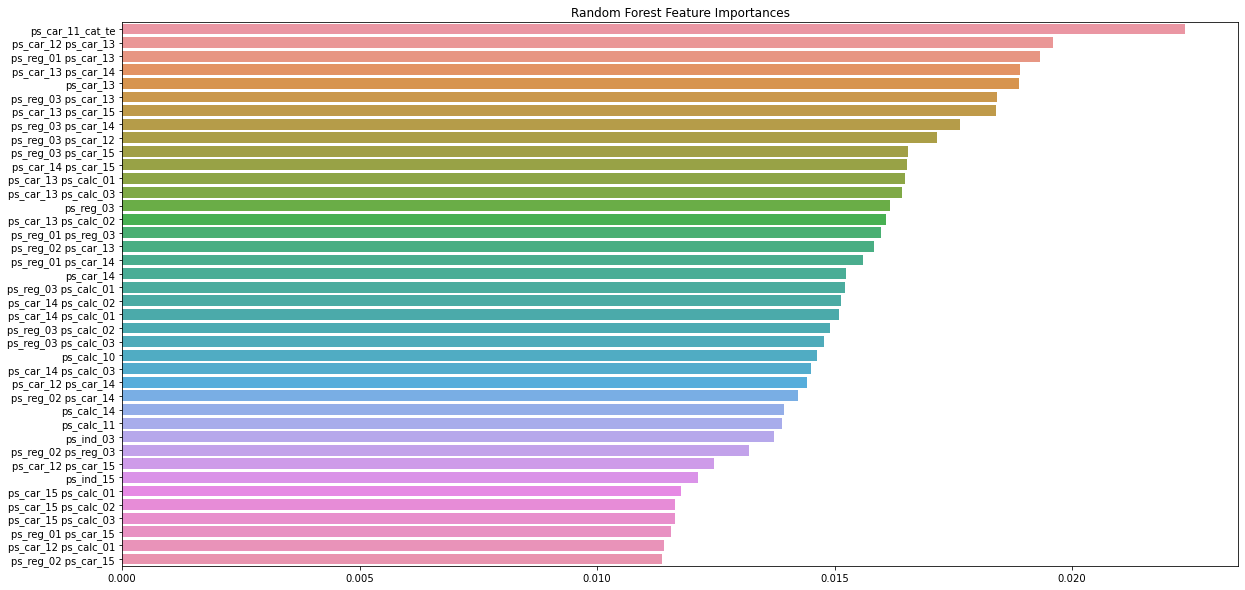

In [80]:
plot_importances(X_features, y_target)

In [88]:
sfm = SelectFromModel(rf, threshold='median', prefit = True)
print('Number of features before selection: {}'.format(X_features.shape[1]))
n_features = sfm.transform(X_features).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(X_features.columns[sfm.get_support()])

Number of features before selection: 152
Number of features after selection: 76


In [90]:
train = train[selected_vars + ['target']]

## Feature Scaling

In [92]:
scaler = StandardScaler()
scaler.fit_transform(train.drop('target', axis = 1))

array([[-0.45941104, -1.26665356,  1.05087653, ...,  0.33629291,
        -1.00982477, -1.01071913],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.01051216,
        -0.41144469, -1.01071913],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  0.33629291,
        -0.86022975, -0.56215309],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.01287878,
         0.48612543,  0.18545696],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.51169547,
         0.48612543, -0.41263108],
       [-0.45941104, -1.26665356,  1.61399304, ..., -0.41193213,
        -0.71063473, -0.11358706]])